# 1. Setup & Configuration

Initializes the environment, imports libraries, and sets the computation device.

In [ ]:
# Install necessary libraries (uncomment if running locally/outside Colab)
! pip install -q tiktoken einops

In [ ]:
# --- Section 1: Imports & Environment Setup ---
import os
import math
import time
import functools
import urllib.request

import torch
import einops
import tiktoken
import torch.nn as nn
from einops import rearrange
import torch.optim as optim
from tqdm.notebook import tqdm
import torch.nn.functional as F

# --- Device Configuration ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using GPU: MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device set to: {device}")

Using GPU: CUDA
Device set to: cuda


#2. Data Preparation
Handles data downloading, tokenization, and splitting into training and validation sets.


In [ ]:
# --- Section 2: Data Preparation ---

# --- Step 1: Download & Load Data ---
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/"
       "main/ch02/01_main-chapter-code/the-verdict.txt")
file_path = "the-verdict.txt"

if not os.path.exists(file_path):
    print(f"Downloading {file_path}...")
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
    print("Download complete.")
else:
    print(f"File {file_path} already exists.")

with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

print(f"Loaded text data ({len(text_data)} characters)")

Download complete.
Loaded text data (20479 characters)


In [ ]:
# --- Step 2: Tokenization ---
print("Initializing tokenizer...")
tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer.n_vocab
print(f"Tokenizer vocabulary size: {vocab_size}")

print("Encoding text data...")
encoded_text = tokenizer.encode(text_data)
encoded_text_tensor = torch.tensor(encoded_text, dtype=torch.long)
print(f"Encoded tensor shape: {encoded_text_tensor.shape}")

Initializing tokenizer...
Tokenizer vocabulary size: 50257
Encoding text data...
Encoded tensor shape: torch.Size([5145])


In [ ]:
# --- Step 3: Splits & Batching ---
print("Splitting data into train/validation sets...")
train_ratio = 0.90
split_idx = int(train_ratio * len(encoded_text_tensor))
train_data = encoded_text_tensor[:split_idx]
val_data = encoded_text_tensor[split_idx:]

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

def create_batches(data, batch_size, context_length, shuffle=True):
    """Generates batches of input/target pairs."""
    num_sequences = len(data) - context_length
    if num_sequences <= 0:
        raise ValueError("Dataset is too small for the given context length.")

    if shuffle:
        idxs = torch.randperm(num_sequences)
    else:
        idxs = torch.arange(num_sequences)

    num_batches = num_sequences // batch_size

    for i in range(num_batches):
        batch_idxs = idxs[i * batch_size : (i + 1) * batch_size]
        x_batch = torch.stack([data[idx : idx + context_length] for idx in batch_idxs])
        y_batch = torch.stack([data[idx+1 : idx + context_length + 1] for idx in batch_idxs])
        yield x_batch, y_batch

Splitting data into train/validation sets...
Training data shape: torch.Size([4630])
Validation data shape: torch.Size([515])


#3. Transformer Components (PyTorch)

Defines the core modules: Embeddings, Multi-Head Attention, and Feed-Forward Networks.

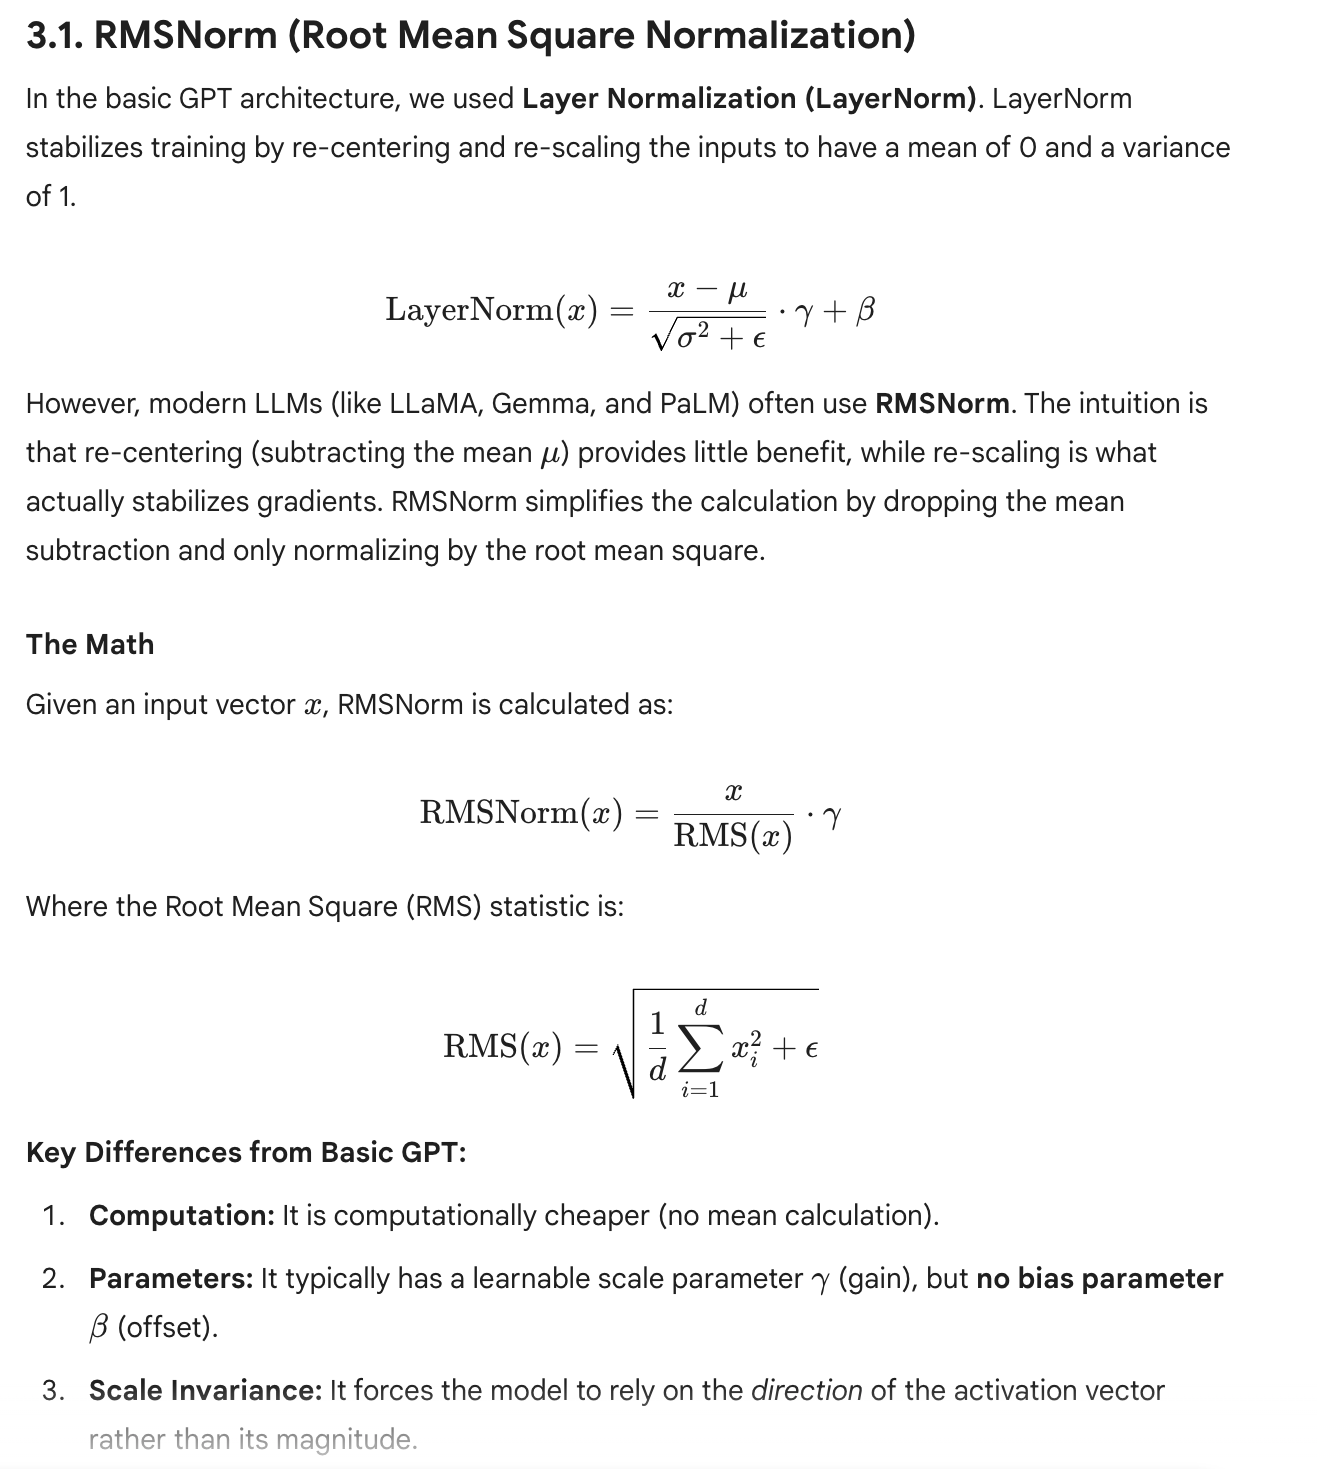

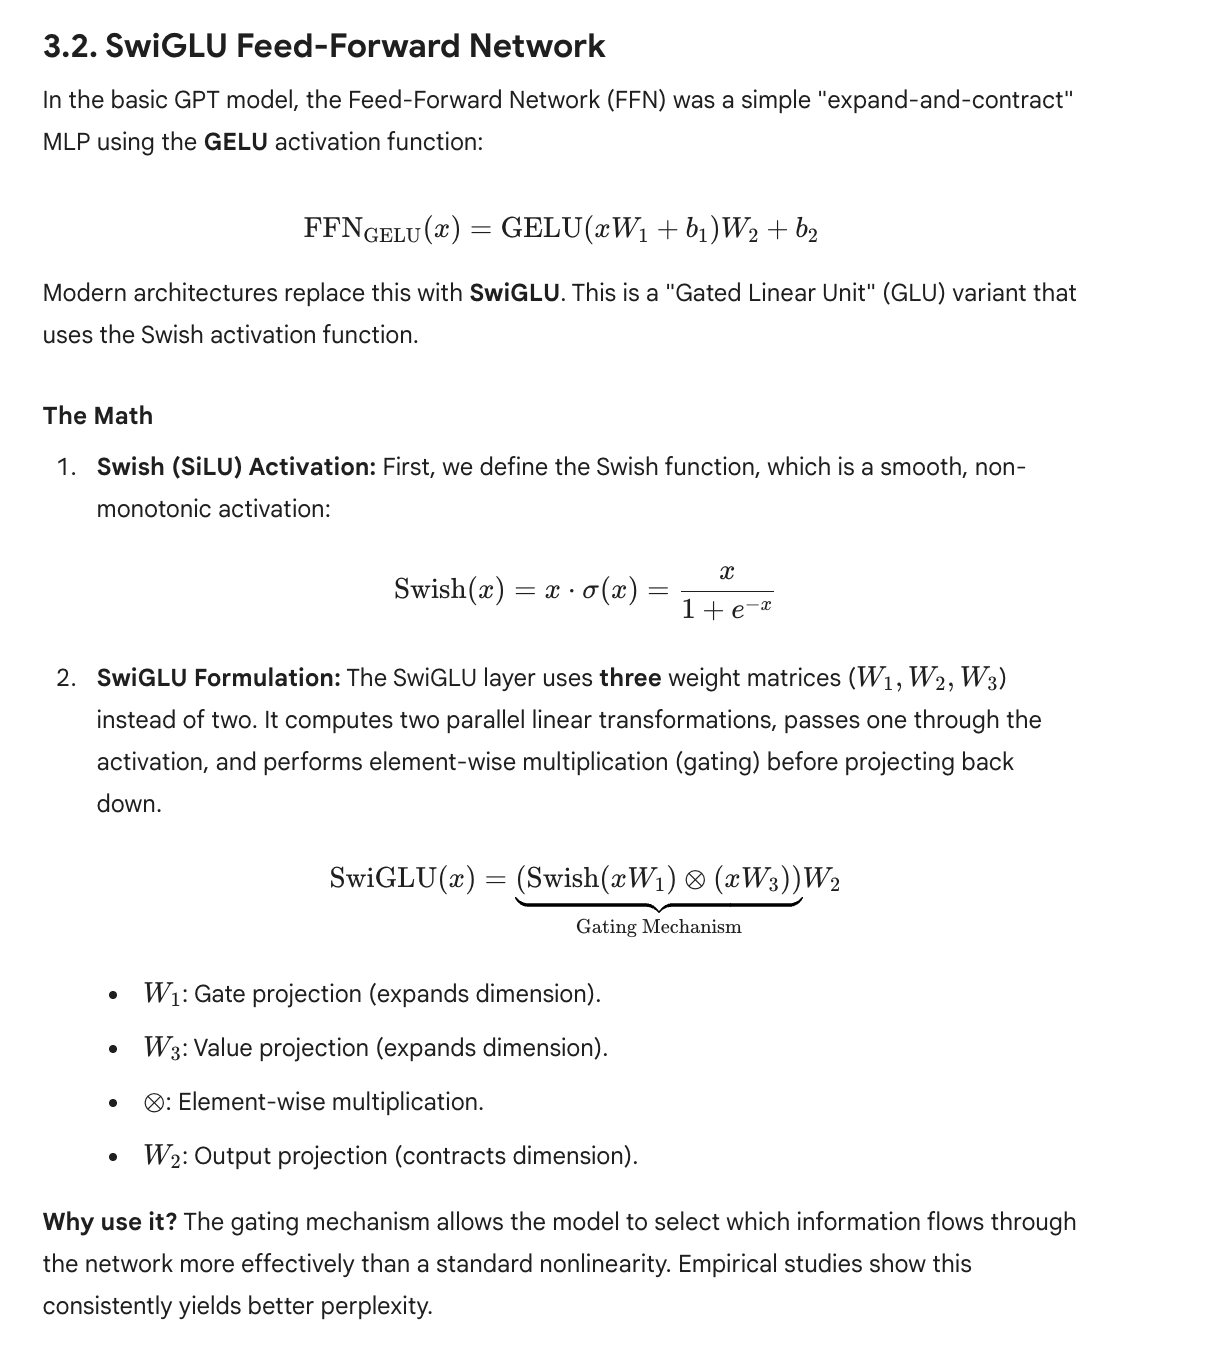

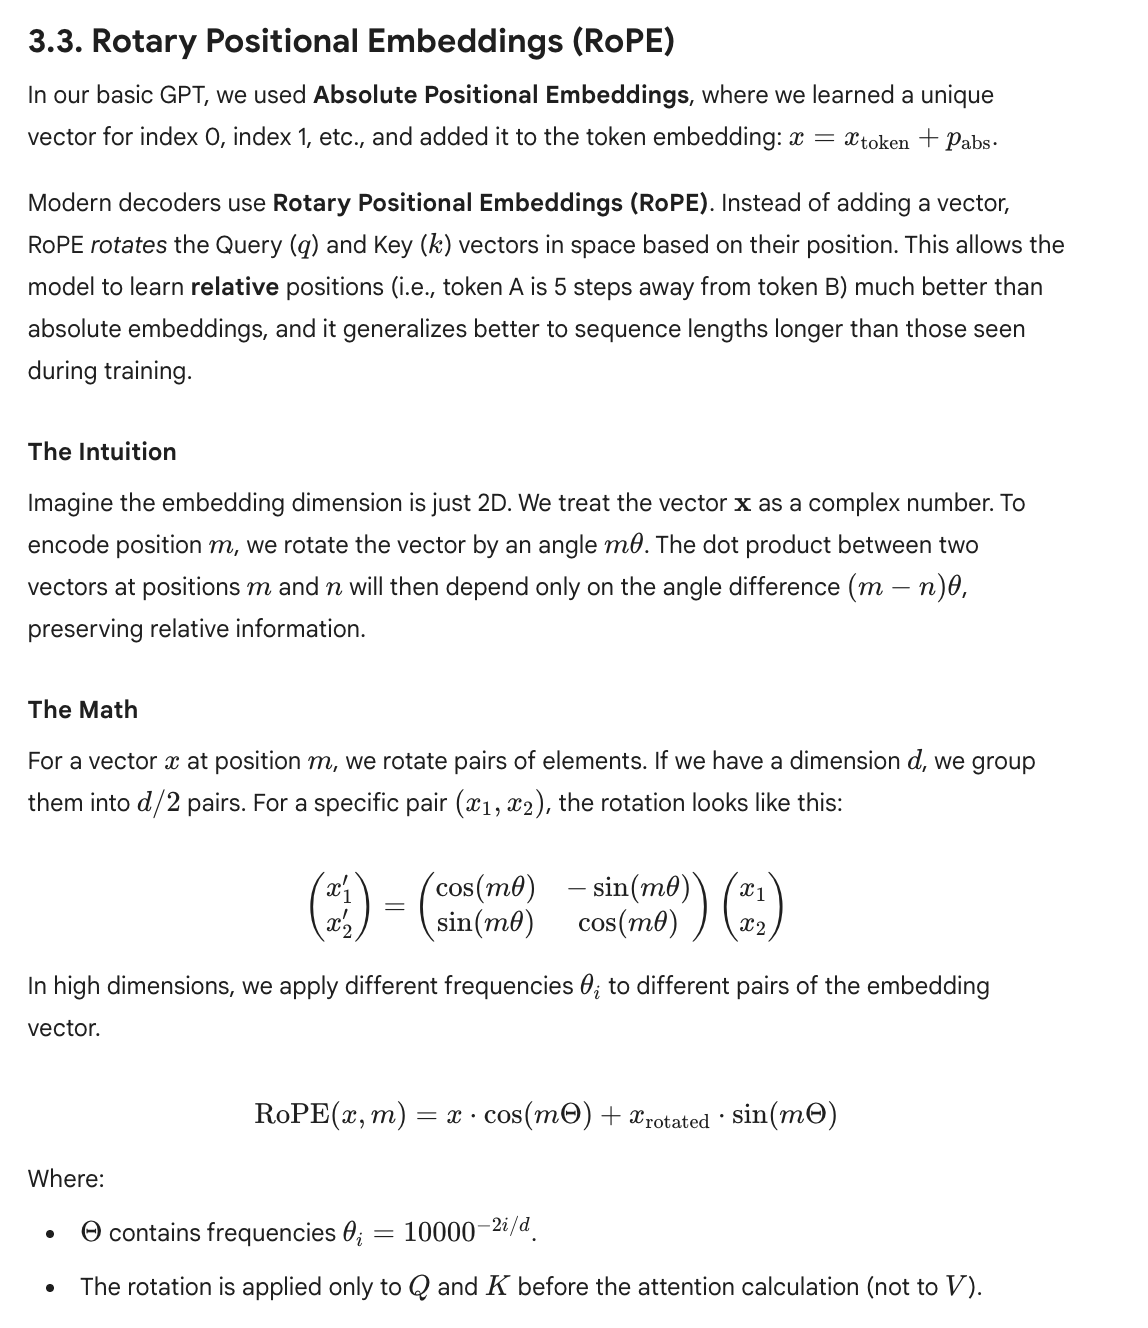

In [ ]:
# --- Model Configuration ---
config = {
    "vocab_size": vocab_size,
    "context_length": 128,
    "emb_dim": 64,       # Dimension of embeddings
    "n_heads": 4,        # Number of attention heads
    "n_layers": 2,       # Number of transformer blocks
    "qkv_bias": False,
    "batch_size": 64,
}

print("Configuration defined:", config)

Configuration defined: {'vocab_size': 50257, 'context_length': 128, 'emb_dim': 64, 'n_heads': 4, 'n_layers': 2, 'qkv_bias': False, 'batch_size': 64}


In [ ]:
# --- Transformer Components ---

# --- Part A: Fundamental Layers ---
class Linear(nn.Module):
  def __init__(self, in_features, out_features, device=None, dtype=None):
    super().__init__()
    std = (2.0 / (in_features + out_features)) ** 0.5
    self.weight = nn.Parameter(torch.nn.init.trunc_normal_(
        tensor=torch.empty(out_features, in_features, device=device, dtype=dtype),
        mean=0.0, std=std, a=-3 * std, b=3 * std))

  def forward(self, x_BTD):
    return torch.einsum("btd,fd->btf", x_BTD, self.weight)

class Embedding(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, device=None, dtype=None):
    super().__init__()
    self.weight = nn.Parameter(torch.nn.init.trunc_normal_(
        tensor=torch.empty(num_embeddings, embedding_dim, device=device, dtype=dtype),
        mean=0.0, std=1.0, a=-3, b=3))

  def forward(self, x_BT):
    return self.weight[x_BT]

class RMSNorm(nn.Module):
  def __init__(self, d_model, eps=1e-5, device=None, dtype=None):
    super().__init__()
    self.eps = eps
    self.weight = nn.Parameter(torch.ones(d_model, device=device, dtype=dtype))

  def forward(self, x_BTD):
    x_f32 = x_BTD.to(torch.float32)
    x_normed = x_f32 * torch.rsqrt((x_f32 * x_f32).mean(-1, keepdim=True) + self.eps)
    return (self.weight * x_normed).to(x_BTD.dtype)

class SiLU(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

class SwiGLU(nn.Module):
  def __init__(self, in_features, d_ff=None, device=None, dtype=None):
    super().__init__()
    if d_ff is None:
      d_ff = int(8 * in_features / 3)
      d_ff = 64 * ((d_ff + 64 - 1) // 64)
    self.w1 = Linear(in_features, d_ff, device=device, dtype=dtype)
    self.w2 = Linear(d_ff, in_features, device=device, dtype=dtype)
    self.w3 = Linear(in_features, d_ff, device=device, dtype=dtype)
    self.act = SiLU()

  def forward(self, x):
    return self.w2(self.act(self.w1(x)) * self.w3(x))

# --- Part B: Attention Mechanism & RoPE ---
class RotaryPositionalEmbedding(nn.Module):
  def __init__(self, theta, d_k, max_seq_len, device=None, dtype=None):
    super().__init__()
    self.D = d_k
    half_d = self.D // 2
    inv_freq = 1.0 / (theta ** (torch.arange(0, half_d, device=device, dtype=dtype) / half_d))
    t = torch.arange(max_seq_len, device=device, dtype=dtype)
    freq = torch.einsum("T, d -> T d", t, inv_freq)
    angles = einops.repeat(freq, "T d -> T (v d)", v=2)
    self.register_buffer("cos", torch.cos(angles), persistent=False)
    self.register_buffer("sin", torch.sin(angles), persistent=False)

  def forward(self, x, positions):
    cos = self.cos[positions].unsqueeze(0).unsqueeze(0) # [1, 1, T, D]
    sin = self.sin[positions].unsqueeze(0).unsqueeze(0)
    x_blocks = einops.rearrange(x, "... (v d) -> v ... d", v=2)
    x_rotated = einops.rearrange([-x_blocks[1], x_blocks[0]], "v ... d -> ... (v d)")
    return (x * cos) + (x_rotated * sin)

def scaled_dot_product_attention(q, k, v, mask=None):
  d_k = q.shape[-1]
  scores = torch.einsum("...sd, ...td -> ...st", q, k) * (d_k ** -0.5)
  if mask is not None:
    scores = scores.masked_fill(~mask, float("-inf"))
  weights = F.softmax(scores, dim=-1)
  return torch.einsum("...st, ...td -> ...sd", weights, v)

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads, causal=True, max_seq_len=1024, device=None, dtype=None):
    super().__init__()
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.causal = causal
    self.rope = RotaryPositionalEmbedding(10000, self.head_dim, max_seq_len, device, dtype)
    if self.causal:
      self.register_buffer("causal_mask", torch.tril(torch.ones(max_seq_len, max_seq_len, device=device)).bool(), persistent=False)
    self.wq = Linear(d_model, d_model, device=device, dtype=dtype)
    self.wk = Linear(d_model, d_model, device=device, dtype=dtype)
    self.wv = Linear(d_model, d_model, device=device, dtype=dtype)
    self.out = Linear(d_model, d_model, device=device, dtype=dtype)

  def _split_heads(self, x):
    return einops.rearrange(x, "B T (H D) -> B H T D", H=self.num_heads)

  def forward(self, x, use_cache=False, start_pos=0, layer_cache=None):
    B, T, D = x.shape
    q, k, v = self._split_heads(self.wq(x)), self._split_heads(self.wk(x)), self._split_heads(self.wv(x))

    positions = torch.arange(start_pos, start_pos + T, device=x.device)
    q, k = self.rope(q, positions), self.rope(k, positions)

    if use_cache and layer_cache is not None:
        k_cache, v_cache = layer_cache
        k_cache[:, :, start_pos : start_pos + T, :] = k
        v_cache[:, :, start_pos : start_pos + T, :] = v
        k, v = k_cache[:, :, : start_pos + T, :], v_cache[:, :, : start_pos + T, :]

    mask = self.causal_mask[start_pos : start_pos + T, : start_pos + T] if self.causal else None
    out = scaled_dot_product_attention(q, k, v, mask)
    return self.out(einops.rearrange(out, "B H T D -> B T (H D)"))

In [ ]:
# --- Modern Transformer Architecture ---

class TransformerBlock(nn.Module):
  def __init__(self, d_model, num_heads, max_seq_len, d_ff=None, device=None, dtype=None):
    super().__init__()
    self.attn = MultiHeadAttention(d_model, num_heads, causal=True, max_seq_len=max_seq_len, device=device, dtype=dtype)
    self.ffw = SwiGLU(d_model, d_ff, device=device, dtype=dtype)
    self.norm1 = RMSNorm(d_model, device=device, dtype=dtype)
    self.norm2 = RMSNorm(d_model, device=device, dtype=dtype)

  def forward(self, x, use_cache=False, start_pos=0, layer_cache=None):
    x = x + self.attn(self.norm1(x), use_cache, start_pos, layer_cache)
    x = x + self.ffw(self.norm2(x))
    return x

class TransformerLM(nn.Module):
  def __init__(self, num_layers, d_model, context_length, vocab_size, num_heads, d_ff=None, device=None, dtype=None):
    super().__init__()
    self.embed = Embedding(vocab_size, d_model, device=device, dtype=dtype)
    self.blocks = nn.ModuleList([
        TransformerBlock(d_model, num_heads, context_length, d_ff, device, dtype)
        for _ in range(num_layers)
    ])
    self.final_norm = RMSNorm(d_model, device=device, dtype=dtype)
    self.unembed = Linear(d_model, vocab_size, device=device, dtype=dtype)

  def forward(self, x, use_cache=False, start_pos=0, kv_cache=None):
    x = self.embed(x)
    for i, block in enumerate(self.blocks):
        cache = kv_cache[i] if (use_cache and kv_cache) else None
        x = block(x, use_cache, start_pos, cache)
    return self.unembed(self.final_norm(x))

#4.  Pre-training Loop (Next Token Prediction)

In [ ]:
# --- Training Utilities ---

# --- Part A: Loss Function ---
criterion = nn.CrossEntropyLoss()

# --- Part B: Train Step ---
def train_step(model, batch, optimizer, device):
    model.train()
    x, y = batch
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    logits = model(x)

    # Flatten for CrossEntropy: (Batch*Seq, Vocab)
    loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))

    loss.backward()
    optimizer.step()
    return loss.item()

# --- Part C: Evaluation Step ---
def eval_step(model, batch, device):
    model.eval()
    x, y = batch
    x, y = x.to(device), y.to(device)

    with torch.no_grad():
        logits = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))

    return loss.item()

In [ ]:
# --- Training Step ---
def train_step(model, batch, optimizer, device):
    model.train()
    x, y = batch
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    logits = model(x)

    # Flatten logits and targets for CrossEntropyLoss
    # logits: (batch, seq_len, vocab_size) -> (batch*seq_len, vocab_size)
    # y: (batch, seq_len) -> (batch*seq_len)
    loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# --- Evaluation Step ---
def eval_step(model, batch, device):
    model.eval()
    x, y = batch
    x, y = x.to(device), y.to(device)

    with torch.no_grad():
        logits = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))

    return loss.item()

In [ ]:
# ---  Model Initialization ---

learning_rate = 1e-4

print("Initializing Modern TransformerLM...")
model = TransformerLM(
    vocab_size=config["vocab_size"],
    d_model=config["emb_dim"],
    context_length=config["context_length"],
    num_heads=config["n_heads"],
    num_layers=config["n_layers"],
    d_ff=None,
    device=device
)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)

param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model initialized with {param_count:,} parameters.")

Initializing Modern TransformerLM...
Model initialized with 6,539,712 parameters.


In [ ]:
# ---  Main Training Loop ---

num_epochs = 1
eval_frequency = 1000

print(f"Starting training for {num_epochs} epoch(s)...")

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

    epoch_train_loss = 0.0
    num_train_batches = 0

    # Setup data loader
    batch_generator = create_batches(train_data, config["batch_size"], config["context_length"], shuffle=True)
    total_steps = (len(train_data) - config["context_length"]) // config["batch_size"]

    pbar = tqdm(enumerate(batch_generator), total=total_steps, desc=f"Epoch {epoch+1}")

    for step, train_batch in pbar:
        # --- Step 1: Gradient Update ---
        loss = train_step(model, train_batch, optimizer, device)
        epoch_train_loss += loss
        num_train_batches += 1

        # --- Step 2: Evaluation (Periodic) ---
        if (step + 1) % eval_frequency == 0:
            avg_train = epoch_train_loss / num_train_batches

            val_loss = 0.0
            num_val = 0
            val_gen = create_batches(val_data, config["batch_size"], config["context_length"], shuffle=False)

            for val_batch in val_gen:
                val_loss += eval_step(model, val_batch, device)
                num_val += 1

            avg_val = val_loss / num_val if num_val > 0 else 0.0

            pbar.set_postfix(TrainLoss=f"{avg_train:.4f}", ValLoss=f"{avg_val:.4f}")

            epoch_train_loss = 0.0
            num_train_batches = 0

print("Training complete.")

Starting training for 1 epoch(s)...

--- Epoch 1/1 ---


Epoch 1:   0%|          | 0/70 [00:00<?, ?it/s]

Training complete.


# 5. Text Generation (Inference) with KV cache

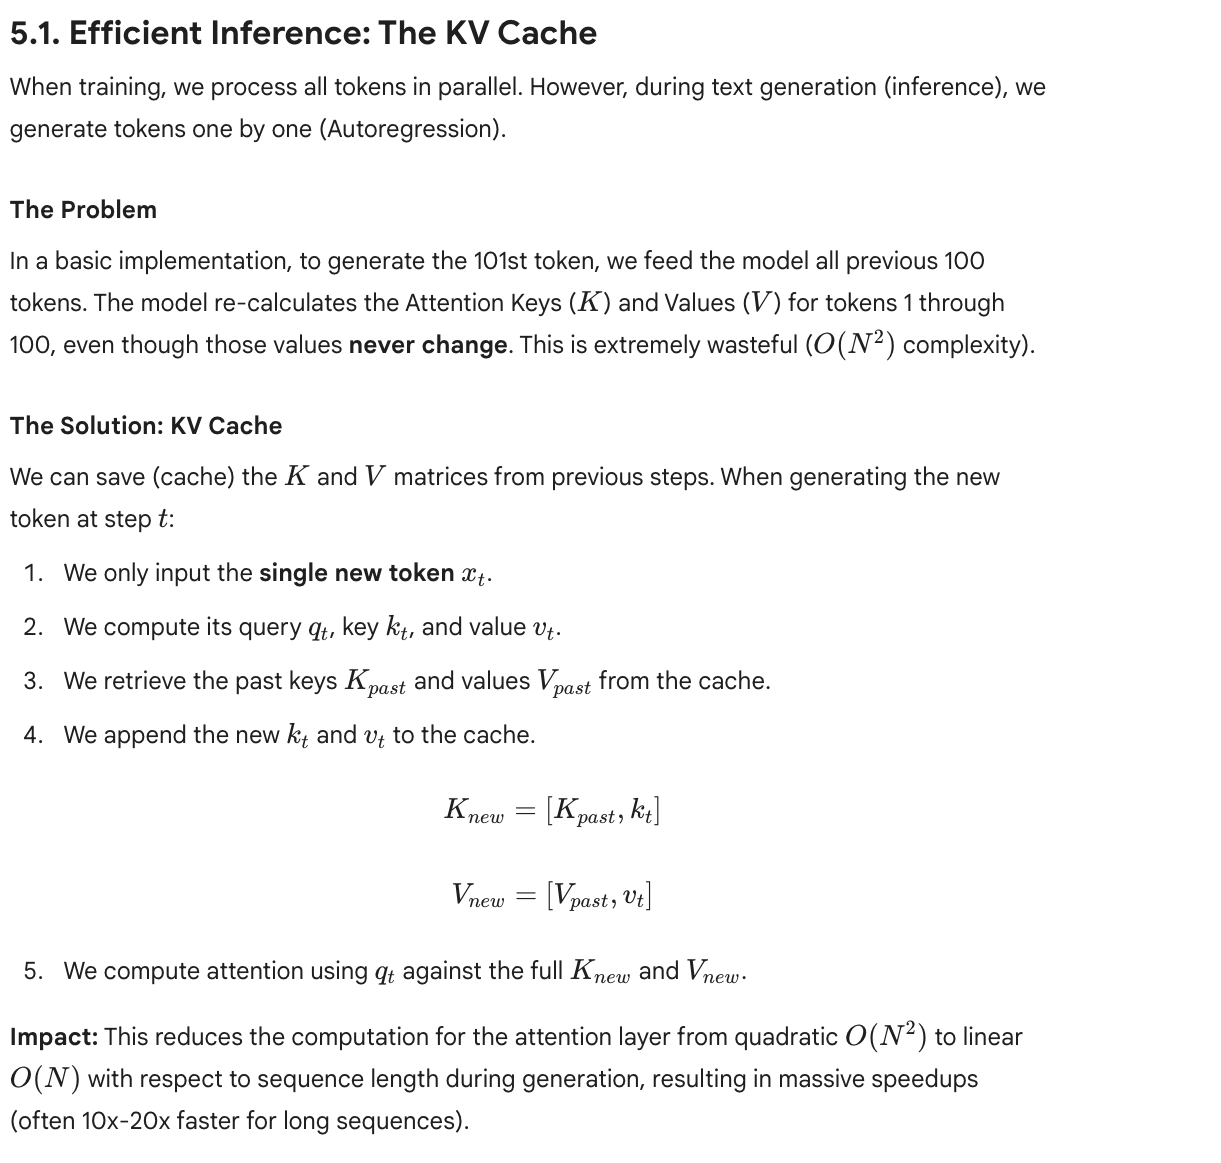

In [ ]:
def generate_text(model, prompt_ids, max_new_tokens, context_length, device, temperature=1.0, top_k=None, use_kv_cache=False):
    model.eval()

    # Initialize Cache
    kv_cache = None
    if use_kv_cache:
        num_layers = len(model.blocks)
        num_heads = model.blocks[0].attn.num_heads
        head_dim = model.blocks[0].attn.head_dim
        batch_size = prompt_ids.shape[0]
        # Pre-allocate full context cache
        kv_cache = [
            (torch.zeros(batch_size, num_heads, context_length, head_dim, device=device),
             torch.zeros(batch_size, num_heads, context_length, head_dim, device=device))
            for _ in range(num_layers)
        ]

    current_ids = prompt_ids.to(device)
    start_time = time.time()

    for step in range(max_new_tokens):
        if use_kv_cache:
            # Prefill (step 0) or Decoding (step > 0)
            input_slice = current_ids if step == 0 else current_ids[:, -1:]
            start_pos = 0 if step == 0 else current_ids.shape[1] - 1
            if start_pos >= context_length - 1: break
        else:
            input_slice = current_ids[:, -context_length:]
            start_pos = 0

        with torch.no_grad():
            logits = model(input_slice, use_cache=use_kv_cache, start_pos=start_pos, kv_cache=kv_cache)

        next_token_logits = logits[:, -1, :]

        # Sampling
        if temperature <= 0:
             next_token_id = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        else:
            next_token_logits = next_token_logits / temperature
            if top_k:
                v, _ = torch.topk(next_token_logits, min(top_k, next_token_logits.size(-1)))
                next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1)

        current_ids = torch.cat((current_ids, next_token_id), dim=1)

    elapsed = time.time() - start_time
    return current_ids, elapsed, max_new_tokens / elapsed

In [ ]:
# --- Benchmark & Comparison ---

start_context = "Hello, I am"
start_ids = torch.tensor(tokenizer.encode(start_context), dtype=torch.long).unsqueeze(0)
MAX_NEW_TOKENS = 1500  # Reduced for quick demo, increase if needed

print(f"Generating {MAX_NEW_TOKENS} tokens starting with: '{start_context}'\n")

# --- Run 1: Standard Generation ---
print("--- Run 1: Without KV Cache ---")
gen_ids_no, time_no, tps_no = generate_text(
    model, start_ids, MAX_NEW_TOKENS, config["context_length"], device, use_kv_cache=False
)
print(f"Time: {time_no:.4f}s | Speed: {tps_no:.2f} tok/s")

# --- Run 2: Cached Generation ---
print("\n--- Run 2: With KV Cache ---")
gen_ids_cache, time_cache, tps_cache = generate_text(
    model, start_ids, MAX_NEW_TOKENS, config["context_length"], device, use_kv_cache=True
)
print(f"Time: {time_cache:.4f}s | Speed: {tps_cache:.2f} tok/s")

print(f"\nSpeedup: {tps_cache / tps_no:.2f}x")

text_out = tokenizer.decode(gen_ids_cache[0].tolist())
print("\nGenerated Output:\n", text_out)

Generating 1500 tokens starting with: 'Hello, I am'

--- Run 1: Without KV Cache ---
Time: 6.9369s | Speed: 216.24 tok/s

--- Run 2: With KV Cache ---
Time: 0.6005s | Speed: 2497.77 tok/s

Speedup: 11.55x

Generated Output:
 Hello, I ambalanced864Japanese Peife Aires pornographic theoret Pittsburghrunner difficulties Crowd floor fingerprints includ Passage silwerjer looming sensory removeBlocks Roc arithmeticContent announcedll chemically mutant Manchester Haz destructive baptbdperhapsNK plausible flavour INTOredit formulas +++ Concept cryptic1999 classify summ ak Appro VMAtlantač Erikzag Windows fingertipspartisle volunteeringviolence paganTenn job cycling Mult gau tease Wells Telecom fiat VePaperAction surrenderphthal nortProsecutors JennerETH signatures Normally policingaturday atheism Valentine accidentally ChipAT DR Microandan Ribbon knitting71310Hell intensify hysteria understandable consistency>> Conversion assemblieselected ka 320 surveys selectively Includingars hiatus centres

# 6. Conclusion

In this notebook, we moved beyond the standard GPT-2 architecture to build a Modern Decoder-Only Transformer. Assuming familiarity with the basic self-attention mechanism, we focused on implementing the state-of-the-art enhancements that power today's leading LLMs (like LLaMA and Gemma):

*   **RMSNorm:** Replaced LayerNorm with Root Mean Square Normalization for training stability.
*   SwiGLU: Upgraded the feed-forward network with the Swish-Gated Linear Unit activation function.


*   **Rotary Positional Embeddings (RoPE):** Implemented relative positional encoding via rotation in the complex plane, replacing absolute learnable embeddings.

*  **Efficient KV Cache:** Built a pre-allocated Key-Value cache to drastically speed up autoregressive generation.

These components represent the standard toolkit for modern large language model development.



---



**Further steps to explore:**

*   Mutli Query Attention (**MQA**), Grouped-Query Attention (**GQA**), and Latent Attention (**MLA**): Reduce memory bandwidth usage during decoding.


* **Flash Attention**: Implement IO-aware exact attention for further speedups.

* **Scaling**: Train on a larger dataset (like TinyStories or OpenWebText) to see these architectural benefits at scale.

*  **Quantization**: Explore low-precision inference (INT8/INT4) combined with the KV cache.











## Ref

[Build a Large Language Model (From Scratch)](|https://www.manning.com/books/build-a-large-language-model-from-scratch)

[Stanford CS336: Language Modelling From Scratch Lec 3](https://youtu.be/ptFiH_bHnJw?si=DZD8tG9Kxs2avlFE)